In [2]:
# https://data.cdc.gov/Vaccinations/COVID-19-Vaccinations-in-the-United-States-County/8xkx-amqh gives date-wise data
# (and plots) on vaccination (equity) status per county (identified by FIPS Code) of the country (USA).
# https://www.nrcs.usda.gov/wps/portal/nrcs/detail/national/home/?cid=nrcs143_013697 gives (USA) county FIPS Codes
# mapped to states.
# https://www.nber.org/research/data/county-distance-database gives (USA) inter-county distances (in miles).
# Consider a scenario as on a chosen date. (Specifying a date drastically reduces the quantum of relevant data.)
# Imagine the country administration seeks an optimal allocation (to counties)
# of limited vaccine production. "Optimal" could be versus Objectives of:
# - maximizing allocation to counties with most-incompletely-vaccinated population (using `Completeness_pct` and
#   `Census2019`, and maybe as a more-advanced consideration, where severity `SVI-CTGY` is higher).
# - minimizing "cost" through a surrogate variable: county's distance from (states of) vaccine manufacture.
# Now, generate that optimization and an optimal output.
c.chosenDate <- "2022/05/14" # Was: == "05/14/2022"
getwd(); myDir <- file.path("."); myDir # , "optVaccine/"
warning("Beware: following code attempts reading in over 350MB data, maybe over a network. Comment this once ready.")

[1] "C:/Users/SONY/Downloads/optVaccine"

[1] "."

Warning message in eval(expr, envir, enclos):
"Beware: following code attempts reading in over 350MB data, maybe over a network. Comment this once ready."


In [20]:
c.mustDebug <- TRUE
myDebug <- function(obj, arg.mustDebug=c.mustDebug){
    if(arg.mustDebug){ print(obj) } # else continue.
    return()
}
transportVaccineMi <- function(fips, county2distRepo=dat.distance, stateFIPSrepo=dat.FIPS,
                               vaccineStateOrig=c("MI", "WI", "KY", "TN"), aggFUN=median){
    if(is.na(fips)){
        fips.aggDist <- NA
    } else {
        # Michigan, Wisconsin, Kentucky, and Tennessee are the assumed vaccine-manufacturing states.
        vso.counties <- stateFIPSrepo[stateFIPSrepo$State %in% vaccineStateOrig, "FIPS5"]
        c2dr.fips <- county2distRepo[(county2distRepo$county1 == fips),]
        c2dr.fips.vsoc <- c2dr.fips[(c2dr.fips$county2 %in% vso.counties),]
            # WHERE (county1==fips) AND (county2 IN vso.counties)
            # Beware: https://stackoverflow.com/questions/6558921/boolean-operators-and
        myDebug(str(c2dr.fips.vsoc))
        # fips.tree <- county2distRepo[c2dr.relevant,]
        if(nrow(c2dr.fips.vsoc) > 0){
            myDebug(c2dr.fips.vsoc)
            fips.aggDist <- aggFUN(c2dr.fips.vsoc$mi_to_county, na.rm=TRUE)
                # do.call(what=aggFUN, args=list(c2dr.fips.vsoc$mi_to_county))
            } else { # did not get any county-specific distances to aggregate
            fips.aggDist <- NA
        }
    }
    return(fips.aggDist)
}

In [4]:
dat.FIPS <- read.csv(file=file.path(myDir, "UScountyFIPScodes-nrcsUsdaGov.csv"),
                    colClasses=c("integer", rep("factor", times=3))) # stringsAsFactors=FALSE)
str(dat.FIPS)

'data.frame':	3232 obs. of  4 variables:
 $ FIPS : int  1001 1003 1005 1007 1009 1011 1013 1015 1017 1019 ...
 $ Name : Factor w/ 1933 levels "Abbeville","Acadia",..: 91 98 109 162 177 237 247 260 313 335 ...
 $ State: Factor w/ 56 levels "AK","AL","AR",..: 2 2 2 2 2 2 2 2 2 2 ...
 $ FIPS5: Factor w/ 3228 levels "01001","01003",..: 1 2 3 4 5 6 7 8 9 10 ...


In [5]:
warning("Beware: following distance data being read in is over 330MB.")
dat.distance <- read.csv(file=file.path(myDir, "sf12010countydistancemiles.csv"),
                        colClasses=c("character", "numeric", "character"))
    # coz reading in as factor causes level mismatches upon comparison later.
    # Was: c("factor", "numeric", "factor")) # stringsAsFactors=FALSE)
# https://stackoverflow.com/questions/24594981/getting-the-error-level-sets-of-factors-are-different-when-running-a-for-loop.
dat.distance$county1 <- factor(dat.distance$county1, levels=levels(dat.FIPS$FIPS5))
dat.distance$county2 <- factor(dat.distance$county2, levels=levels(dat.FIPS$FIPS5))
str(dat.distance); summary(dat.distance)

Warning message in eval(expr, envir, enclos):
"Beware: following distance data being read in is over 330MB."


'data.frame':	10371620 obs. of  3 variables:
 $ county1     : Factor w/ 3228 levels "01001","01003",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ mi_to_county: num  22.5 26.8 29.5 30.8 34.5 ...
 $ county2     : Factor w/ 3228 levels "01001","01003",..: 11 43 26 24 51 19 53 4 59 66 ...


    county1          mi_to_county         county2        
 01001  :    3220   Min.   :   1.408   01001  :    3220  
 01003  :    3220   1st Qu.: 494.739   01003  :    3220  
 01005  :    3220   Median : 806.898   01005  :    3220  
 01007  :    3220   Mean   : 952.651   01007  :    3220  
 01009  :    3220   3rd Qu.:1235.713   01009  :    3220  
 (Other):10326540   Max.   :6273.088   (Other):10326540  
 NA's   :   28980                      NA's   :   28980  

In [17]:
dat.distance <- na.omit(dat.distance) # Alt: na.exclude() which retains exclusion info used by some functions.
str(dat.distance); summary(dat.distance)

'data.frame':	10313732 obs. of  3 variables:
 $ county1     : Factor w/ 3228 levels "01001","01003",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ mi_to_county: num  22.5 26.8 29.5 30.8 34.5 ...
 $ county2     : Factor w/ 3228 levels "01001","01003",..: 11 43 26 24 51 19 53 4 59 66 ...
 - attr(*, "na.action")= 'omit' Named int [1:57888] 2651 2929 2985 3188 3189 3190 3193 3195 3217 5807 ...
  ..- attr(*, "names")= chr [1:57888] "2651" "2929" "2985" "3188" ...


    county1          mi_to_county         county2        
 01001  :    3211   Min.   :   1.408   01001  :    3211  
 01003  :    3211   1st Qu.: 493.162   01003  :    3211  
 01005  :    3211   Median : 803.584   01005  :    3211  
 01007  :    3211   Mean   : 944.892   01007  :    3211  
 01009  :    3211   3rd Qu.:1226.756   01009  :    3211  
 01011  :    3211   Max.   :6273.088   01011  :    3211  
 (Other):10294466                      (Other):10294466  

In [6]:
warning("Beware: following distance data being read in is over 350MB.")
dat.8xkx.amqh <- read.csv(file=file.path(myDir, "COVID-19_Vaccinations_in_the_United_States_County.csv"),
                          stringsAsFactors=TRUE)
  # https://data.cdc.gov/resource/8xkx-amqh.json is the Socrates Open Data API (SODA) endpoint.
  # That could be accessed programmatically at runtime using R package `RSocrates` or equivalent.
  # It's about 350MB and is updated daily. So, downloaded into CSV for alternative access.

Warning message in eval(expr, envir, enclos):
"Beware: following distance data being read in is over 350MB."


In [7]:
dat.8xkx.amqh$Date <- as.Date(dat.8xkx.amqh$Date, format="%m/%d/%Y") # convert factor type to date.
dat.8xkx.amqh$FIPS <- factor(dat.8xkx.amqh$FIPS, levels=levels(dat.FIPS$FIPS5))
str(dat.8xkx.amqh)

'data.frame':	1700101 obs. of  66 variables:
 $ Date                                   : Date, format: "2022-05-14" "2022-05-14" ...
 $ FIPS                                   : Factor w/ 3228 levels "01001","01003",..: 3093 18 158 163 185 212 250 361 400 537 ...
 $ MMWR_week                              : int  19 19 19 19 19 19 19 19 19 19 ...
 $ Recip_County                           : Factor w/ 1960 levels "Abbeville County",..: 1329 416 1192 1374 17 1224 315 1187 236 1887 ...
 $ Recip_State                            : Factor w/ 61 levels "","AK","AL","AR",..: 59 3 4 4 7 7 8 12 14 14 ...
 $ Completeness_pct                       : num  96.8 92.5 90.5 90.5 97.6 97.6 97.1 98.7 89.4 89.4 ...
 $ Administered_Dose1_Recip               : int  69678 6882 3869 10536 1514677 120184 14166 70330 31430 2348 ...
 $ Administered_Dose1_Pop_Pct             : num  78.1 57 43.1 59.3 90.6 87.3 69.6 94.7 39.5 29.9 ...
 $ Administered_Dose1_Recip_5Plus         : int  69662 6882 3867 10529 1511943 120031

In [8]:
# plot(Completeness_pct ~ Date, data=dat.8xkx.amqh[dat.8xkx.amqh$FIPS == "01001",]) # explore for a county.
myData <- dat.8xkx.amqh[(dat.8xkx.amqh$Date == c.chosenDate),
                        c("Date", "FIPS", "Completeness_pct", "SVI_CTGY", "Census2019")]
str(myData); summary(myData)

'data.frame':	3284 obs. of  5 variables:
 $ Date            : Date, format: "2022-05-14" "2022-05-14" ...
 $ FIPS            : Factor w/ 3228 levels "01001","01003",..: 3093 18 158 163 185 212 250 361 400 537 ...
 $ Completeness_pct: num  96.8 92.5 90.5 90.5 97.6 97.6 97.1 98.7 89.4 89.4 ...
 $ SVI_CTGY        : Factor w/ 5 levels "","A","B","C",..: 2 5 4 5 3 4 2 3 5 5 ...
 $ Census2019      : int  89221 12067 8986 17782 1671329 137744 20356 74228 79608 7855 ...


      Date                 FIPS      Completeness_pct SVI_CTGY
 Min.   :2022-05-14   01001  :   1   Min.   :73.50     : 65   
 1st Qu.:2022-05-14   01003  :   1   1st Qu.:93.60    A:806   
 Median :2022-05-14   01005  :   1   Median :96.80    B:804   
 Mean   :2022-05-14   01007  :   1   Mean   :94.86    C:804   
 3rd Qu.:2022-05-14   01009  :   1   3rd Qu.:97.80    D:805   
 Max.   :2022-05-14   (Other):3208   Max.   :98.90            
                      NA's   :  71   NA's   :23               
   Census2019      
 Min.   :      86  
 1st Qu.:   11131  
 Median :   26108  
 Mean   :  102950  
 3rd Qu.:   67215  
 Max.   :10039107  
 NA's   :63        

In [18]:
testFIPS <- factor(c("01001", "01003"), levels=levels(dat.FIPS$FIPS5)); myDebug(testFIPS)
duh <- sapply(testFIPS, FUN=transportVaccineMi); myDebug(duh)

[1] 01001 01003
3228 Levels: 01001 01003 01005 01007 01009 01011 01013 01015 01017 ... 78030


NULL

'data.frame':	370 obs. of  3 variables:
 $ county1     : Factor w/ 3228 levels "01001","01003",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ mi_to_county: num  180 184 186 189 190 ...
 $ county2     : Factor w/ 3228 levels "01001","01003",..: 2477 2451 2453 2483 2475 2489 2516 2458 2484 2456 ...
 - attr(*, "na.action")= 'omit' Named int [1:57888] 2651 2929 2985 3188 3189 3190 3193 3195 3217 5807 ...
  ..- attr(*, "names")= chr [1:57888] "2651" "2929" "2985" "3188" ...
NULL
     county1 mi_to_county county2
167    01001     180.0915   47103
176    01001     183.6769   47051
181    01001     185.5852   47055
187    01001     188.8507   47115
190    01001     190.4024   47099
192    01001     190.8843   47127
210    01001     198.7605   47181
211    01001     199.2135   47065
219    01001     202.7012   47117
220    01001     203.9420   47061
223    01001     204.2851   47071
228    01001     205.9861   47003
230    01001     206.5502   47031
234    01001     207.8388   47011
235    01001     208.3147  

[1] 412.9011 556.8082


NULL

In [ ]:
# g.tVaccMi.computed <- 0 # init global variable to tr

In [21]:
c.mustDebug <- FALSE # coz about to apply on large dataset
tVaccMi <- sapply(myData$FIPS, FUN=transportVaccineMi)

 num [1:3284] 396 492 602 469 1958 ...


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
  172.6   403.1   580.9   729.5   877.7  4433.4      75 

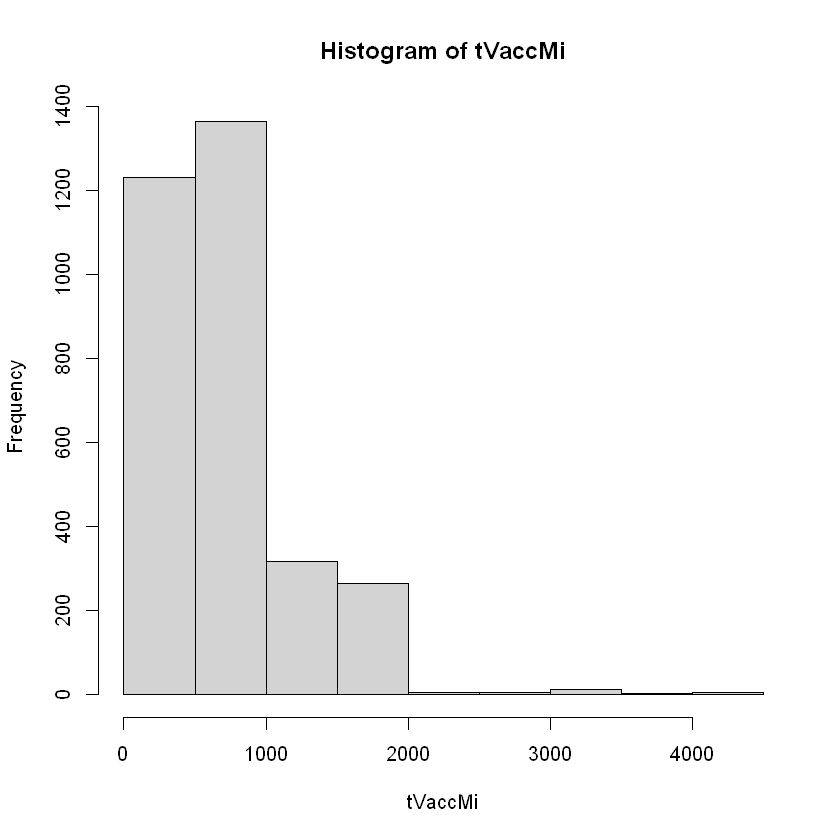

In [22]:
str(tVaccMi); summary(tVaccMi) # just explore whether ok
hist(tVaccMi)

In [23]:
myData.tVaccMi <- cbind(myData, tVaccMi=tVaccMi)

In [25]:
write.csv(myData.tVaccMi, file=file.path(myDir, "myData.tVaccMi.csv"), row.names=FALSE)